# Homework 3: ***Probabilistic Programming*** and ***Probabilistic Graphical Models***

Probabilistic Machine Learning -- Spring 2023, UniTS

<a target="_blank" href="https://colab.research.google.com/github/emaballarin/probml-units/blob/main/homework-2023/03_prob_prog_pgms_HW.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>

Before starting, a read of [the recap notebook on ***Probabilistic Graphical Models***](https://github.com/emaballarin/probml-units/blob/main/notebooks/04_graphical_models.ipynb) is strongly recommended!  
Notebooks [\#1](https://github.com/emaballarin/probml-units/blob/main/notebooks/03a_probabilistic_programming.ipynb) and [\#2](https://github.com/emaballarin/probml-units/blob/main/notebooks/03b_probabilistic_programming.ipynb) about ***Probabilistic Programming*** and inference in `Pyro` may also be useful for the practical part.

In [1]:
import logging
import os

import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pyro
import pyro.distributions as dist

### Exercise 1 (theory: *Bayesian Networks*)

1. Draw the *Bayesian Network* representation of the joint distribution:

$$P(A,B,C,D,E,F,G)=P(A)P(B|A)P(F|B)P(C|A)P(D|B)P(E|D,F)P(G).$$

2. Indicate whether the following statements on (conditional) independence are `True` or `False` in such joint distribution, and motivate your answer.

    (a.) ${~}$ ${~}$ $A\perp \!\!\! \perp D$  
    (b.) ${~}$ ${~}$ $F\perp \!\!\! \perp D$  
    (c.) ${~}$ ${~}$ $A\perp \!\!\! \perp B\ |\ C$  
    (d.) ${~}$ ${~}$ $A\perp \!\!\! \perp D\ |\ B$  
    (e.) ${~}$ ${~}$ $D\perp \!\!\! \perp F\ |\ E$  
    (f.) ${~}$ ${~}$ $B\perp \!\!\! \perp F\ |\ E$  
    (g.) ${~}$ ${~}$ $A\perp \!\!\! \perp D\ |\ \{B, F\}$  

In [20]:
# To represent the Bayesian Network I use pyro's ability to render models. Ignore the distributions are they are just included to show the network as desired
def model():
    A = pyro.sample("A", dist.Normal(0, 1))
    B = pyro.sample("B", dist.Normal(A, 1))
    C = pyro.sample("C", dist.Normal(A, 1))
    D = pyro.sample("D", dist.Normal(B, 1))
    F = pyro.sample("F", dist.LogNormal(B, 1))
    E = pyro.sample("E", dist.Normal(D, F))
    G = pyro.sample("G", dist.Normal(0, 1))

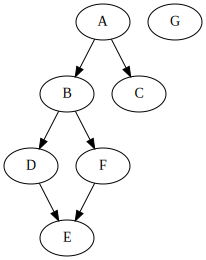

In [21]:
pyro.render_model(model) # Ignore the associated distributions, it was just to plot the model.

$\renewcommand{\indep}{\perp \!\!\! \perp}$

Thanks to pyro ability to render model graphically the one above is the Bayesian Network implied by the factorization of the joint distribution provided.

Now let us assess the conditional independence statements using the following:
For any set of nodes A, B, C a BN implies A $\indep$ B|C iff every path from a node in A to a node in B is blocked by a node in C.\
A path from a node $a \in A$ to $b \in B$ iff it includes at least a node $c \in C$ such that:
- arrows meet tail-to-tail or head-to-tail at $c \in C$.
- arrows meet head-to-head at $d$ and neither $d$ nor any of its descendents belong to C.

Let us consider the various statements:
- $A \indep D$: `True`<br>We can note that the path A-B-D is not blocked because B does not belong to the conditioning set (which is empty in this case) and the path is head to tail at B.
- $F \indep D$: `False`<br>It is not blocked because the path F-B-D is not blocked, since B does not belong to the conditioning set and the path is tail-to-tail at B.
- $A \indep B|C$: `False`<br>Conside the path A-B, it is not blocked as there is no node which can block it.
- $A \indep D|B$: `True`<br>There are two paths from A-B and both are blocked by B. The two paths are A-B-D and A-B-F-E and both are blocked by B since B belongs to the conditioning set and it is head-to-tail in both paths.
- $D \indep F|E$: `False`<br>Consider path D-E-F, it is not blocked because E belongs to the conditioning set but E is head-to-head in the path.
- $B \indep F|E$: `False`<br>Consider path B-D-E-F is is not blocked because 
    - E belongs to the conditioning set but it is head to head.
    - D does not belong to the conditioning set and it's head to tail.
- $A \indep D| B, F$: `True`<br>There are two paths from A to D, A-B-D and A-B-F-E-D and both are blocked by B since B belongs to the conditioning set and it is head to tail in the path.

### Exercise 2 (practicum: *Probabilistic Graphical Models* in `Pyro`)

1. Write the generative model represented by the following directed graph
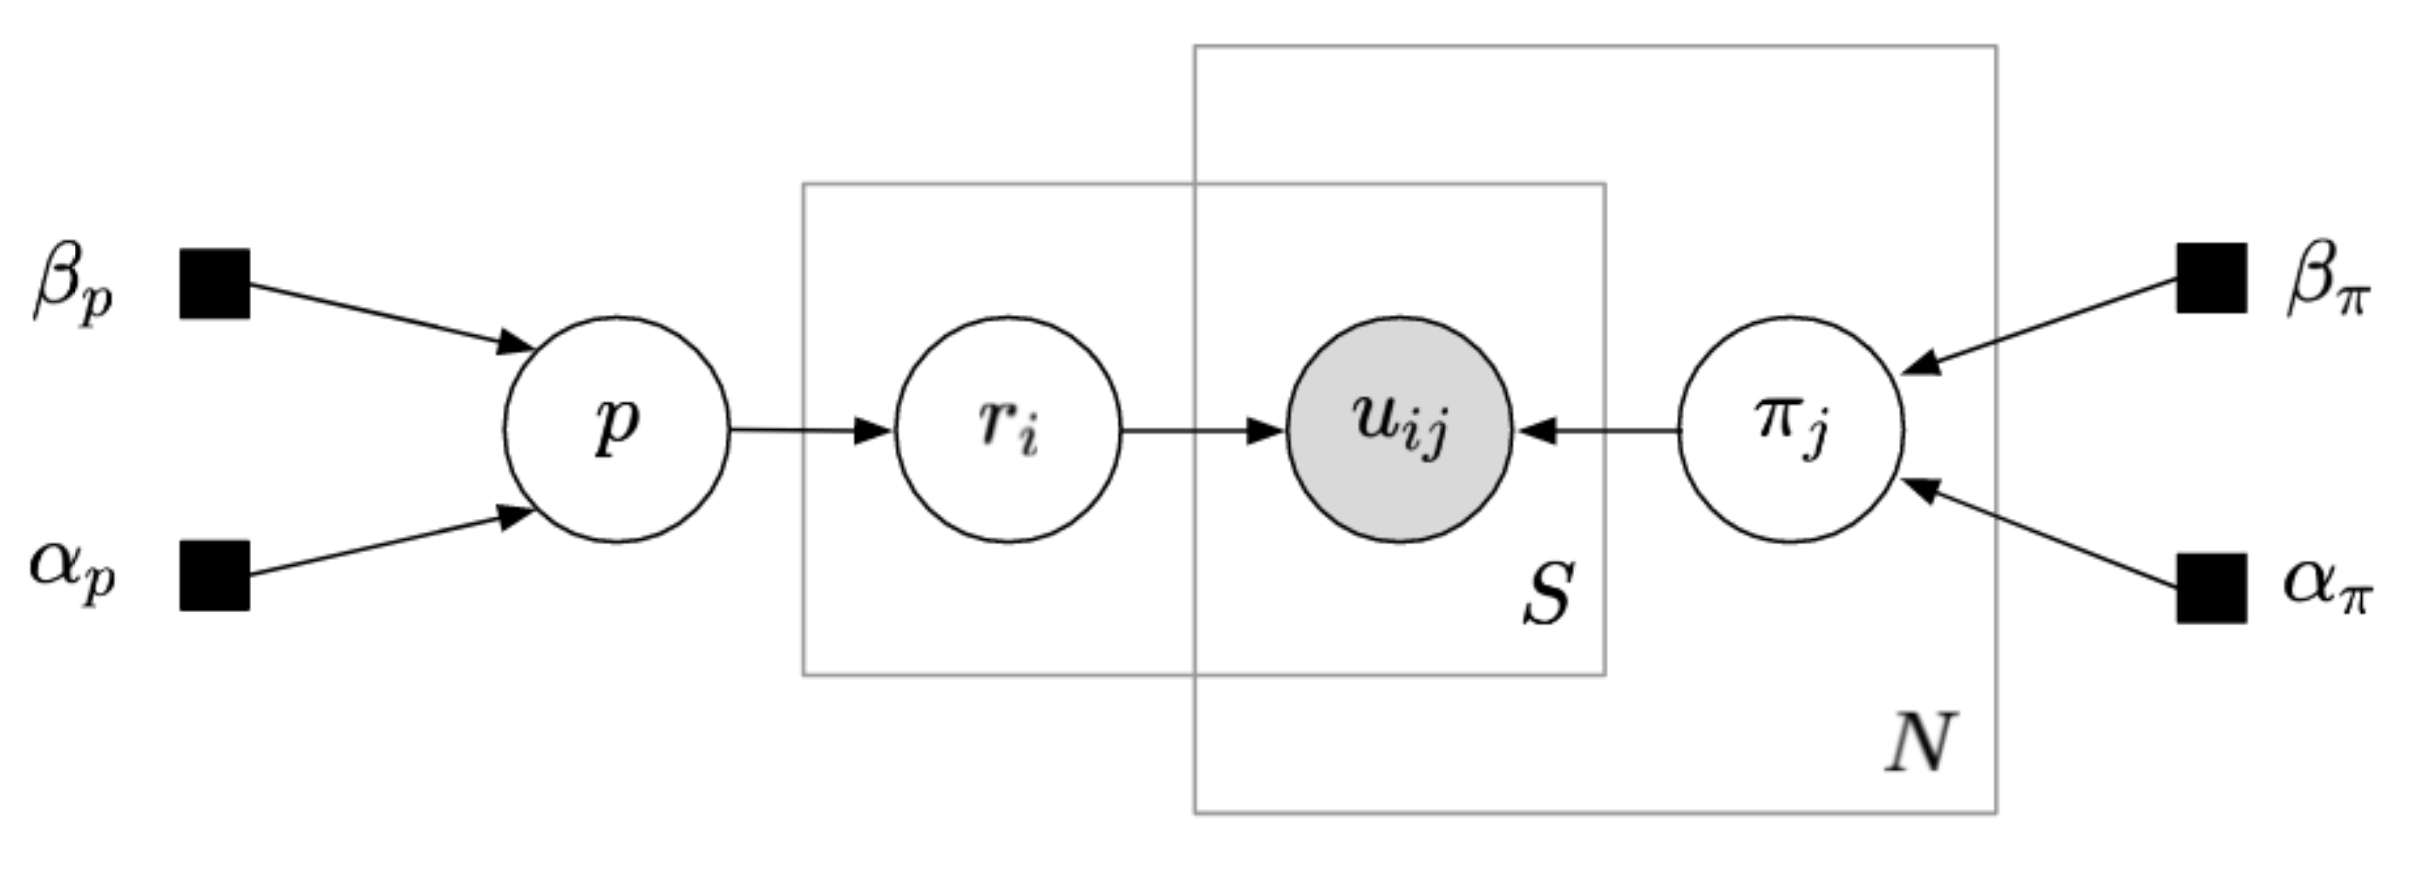
where:  
    i.  )  $p$ and $\pi_j$ are sampled from Beta distributions;  
    ii. )  $r_i$ is sampled from a Bernoulli distribution;  
    iii.)  $u_{ij}$ is sampled from a Bernoulli distribution with parameter $r_i (1 - \pi_j) + (1 - r_i)\pi_j$.  

Here is the representation of the model:
$$
p(p, \mathbf{r}, \mathbf{u}, \mathbf{\pi} | \alpha_\pi, \beta_\pi, \alpha_p, \beta_p) = p(p|\alpha_p, \beta_p) \prod_{i = 1}^{S} \prod_{j = 1}^{N} p(\pi_j | \alpha_\pi, \beta_\pi) p(r_i | p) p(u_{ij}|r_i, \pi_j) 
$$

2. Implement the same generative model in `Pyro`.  
Set the hyperparameters to $\alpha_p=1,\ \ \beta_p=1,\ \ \alpha_\pi=1,\ \ \beta_\pi=5$ and evaluate your model on synthetic observations obtained as `data = pyro.distributions.Bernoulli(0.6).sample((12,6))`.  
Remember to use the *plate notation* adequately and to condition on observed data!  
If you need to jointly *plate* *w.r.t.* different variables, you can use `pyro.plate` context managers as follows:

    ```python
    plate_1 = pyro.plate(...)
    plate_2 = pyro.plate(...)

    with plate_1:
        # do something while plating on plate_1 only
    
    with plate_2:
        # do something while plating on plate_2 only

    with plate_1, plate_2:
        # do something while jointly-plating

In [3]:
data = dist.Bernoulli(0.6).sample((12,6))
data

tensor([[0., 1., 0., 1., 0., 1.],
        [1., 1., 1., 0., 1., 1.],
        [0., 0., 0., 1., 1., 0.],
        [1., 1., 1., 0., 0., 1.],
        [1., 1., 0., 1., 1., 0.],
        [1., 1., 1., 0., 0., 1.],
        [1., 0., 0., 1., 1., 0.],
        [1., 0., 1., 0., 1., 1.],
        [1., 1., 1., 1., 1., 0.],
        [1., 0., 0., 1., 1., 1.],
        [0., 1., 1., 0., 1., 1.],
        [1., 1., 0., 1., 0., 0.]])

In [9]:
# hyperparameters
alpha_p: float = 1.0
beta_p: float = 1.0

alpha_pi: float = 1.0
beta_pi: float = 5.0

def model(data):
    S: int = len(data) # We assume that we have S = 12 and N = 6 from example above
    N: int = len(data[0])
 
    # "Global" variables: 
    p = pyro.sample("p", dist.Beta(alpha_p, beta_p))

    # Define the two plates
    plate_1 = pyro.plate("S_plate", S, dim=-2)
    plate_2 = pyro.plate("N_plate", N, dim=-1)

    with plate_1:
        r = pyro.sample("r", dist.Bernoulli(p))
    with plate_2:
        pi = pyro.sample("pi", dist.Beta(alpha_pi, beta_pi))
    
    with plate_1, plate_2:
            u = pyro.sample("u", dist.Bernoulli(r*(1 - pi) + (1 - r) * pi), obs = data)

    print(f"p = {p}\nr = {r}\npi = {pi}\nu = {u}")
    return(p)

In [16]:
model(data)

p = 0.21865272521972656
r = tensor([[1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]])
pi = tensor([0.2066, 0.2686, 0.0764, 0.2050, 0.0634, 0.1853])
u = tensor([[0., 1., 0., 1., 0., 1.],
        [1., 1., 1., 0., 1., 1.],
        [0., 0., 0., 1., 1., 0.],
        [1., 1., 1., 0., 0., 1.],
        [1., 1., 0., 1., 1., 0.],
        [1., 1., 1., 0., 0., 1.],
        [1., 0., 0., 1., 1., 0.],
        [1., 0., 1., 0., 1., 1.],
        [1., 1., 1., 1., 1., 0.],
        [1., 0., 0., 1., 1., 1.],
        [0., 1., 1., 0., 1., 1.],
        [1., 1., 0., 1., 0., 0.]])


tensor(0.2187)

### Exercise 3 (practicum: *Gaussian Process Classification* in `Pyro`)

Consider an instance of the *Half Moons* dataset, a *toy* dataset for classification featuring two interleaving noisy half-annuli. For the sake of simplicity, it has been already be generated, plotted, and converted to `PyTorch` tensors for you:

In [17]:
import numpy as np
import torch as th
import pyro

import pyro.contrib.gp as gp
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS

from sklearn.datasets import make_moons
from matplotlib import pyplot as plt
import seaborn as sns

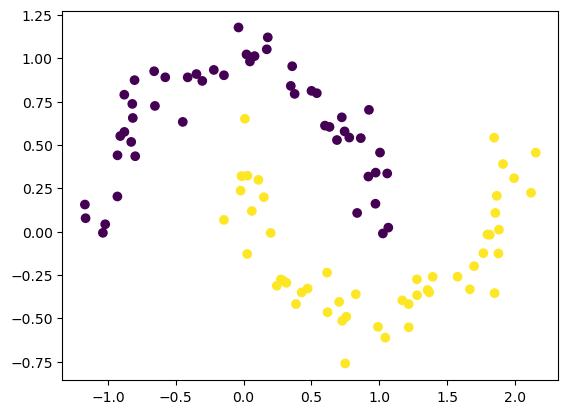

In [18]:
x, y = make_moons(n_samples=100, shuffle=True, noise=0.1, random_state=1)
_ = plt.scatter(x[:, 0], x[:, 1], c=y)

In [19]:
x, y = th.from_numpy(x).float(), th.from_numpy(y).float()

Consider the following generative model:

$$
\begin{align*}
    (y_n \ |\  p_n) &\sim \mathrm{Bern}(p_n) \quad \text{for } n=1,\ldots,N\\
    (\mathrm{logit}(\boldsymbol{p})\ |\ \mu,\sigma,l) &\sim \mathcal{GP}(\mu, K_{\sigma,\  l}(x_n))\\
    \mu &\sim \mathcal{N}(0,1)\\
    \sigma &\sim \mathrm{LogNormal}(0,1)\\
    l &\sim \mathrm{LogNormal}(0,1)
\end{align*}
$$

where we model:
- the binary response variable with a Bernoullian likelihood;
- the logit of the joint probability $\boldsymbol{p} = (p_1, \dots, p_n, \dots, p_N)$ with a Gaussian Process having
    - predictors $x_n$,
    - mean $\mu$: harvested from a standard normal distribution,
    - kernel matrix $K_{\sigma, l}$, parameterized by:
        - variance $\sigma$ and lengthscale $l$: : harvested from two *i.i.d.* standard log-normal distributions.

We want to solve this binary classification problem by means of *Hamiltonian Monte Carlo* inference: this requires a reparametrization of the multivariate Gaussian $\mathcal{GP}(\mu, K_{\sigma,\  l}(x_n))$ for the sake computational efficiency.  

Specifically, we will model logit probability as:

$$\mathrm{logit}(\boldsymbol{p}) = \mu \cdot \mathbf{1}_N + \eta \cdot L,$$

where:
- $L$ is the *Cholesky factor* of $K_{\sigma,\  l}$
- $\eta_n\sim\mathcal{N}(0,1)$.

This relationship is implemented by the `get_logits` function below:


In [20]:
def get_logits(x, mu, sigma, l, eta):
    kernel = gp.kernels.RBF(
        input_dim=2,
        variance=(sigma if isinstance(sigma, th.Tensor) else th.tensor(sigma)),
        lengthscale=(l if isinstance(l, th.Tensor) else th.tensor(l)),
    )
    K = kernel.forward(x, x) + th.eye(x.shape[0]) * 1e-4
    L = th.linalg.cholesky(K)
    return mu + th.mv(L, eta)

Write a pyro model `gp_classifier(x, y, logit_function)` that implements the reparametrized generative model, using `get_logits` function. Remember to `plate` on independent observations!

In [21]:
def gp_classifier(x, y, logit_function):
    N: int = len(y)

    # Generate hyperparameters mu, sigma, l only once
    mu = pyro.sample("mu", dist.Normal(0, 1))
    sigma = pyro.sample("sigma", dist.LogNormal(0,1))
    l = pyro.sample("l", dist.LogNormal(0, 1))

    # Create a plate for generating samples of eta independently of one another.
    # Recall that a plate is equivalent to a for loop, so in the end we have a vector eta.
    with pyro.plate("etas", N):
        eta = pyro.sample("eta", dist.Normal(0, 1))
    
    # Calcolate the logit (i.e. the log odds) for all the observations using the logit_function and hyper-parameters
    logit_p = logit_function(x, mu, sigma, l, eta)        
   
    # Define a plate for the observations using a Bernoulli RV and passing the logit probabiility.
    #   We use obs to condition on the observed data, as these are passed to the model.
    with pyro.plate("observations", N):
        obs = pyro.sample("y", dist.Bernoulli(logits=logit_p), obs = y)

By using `pyro.NUTS` on the `gp_classifier` model, we can infer the posterior distribution of its parameters via the *No U-Turn Sampler*, an effective *HMC* method.  Posterior samples can be extracted using the `.get_samples()` method.

In [22]:
nuts_kernel = NUTS(gp_classifier)
mcmc = MCMC(nuts_kernel, warmup_steps=50, num_samples=10)
posterior = mcmc.run(x=x, y=y, logit_function=get_logits)
mcmc.summary()

Sample: 100%|██████████| 60/60 [04:37,  4.62s/it, step size=8.23e-03, acc. prob=0.238]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
    eta[0]      0.81      0.47      0.61      0.37      1.87      6.40      0.94
    eta[1]      0.33      0.62      0.15     -0.41      1.41      3.36      1.85
    eta[2]     -0.08      0.33     -0.01     -0.77      0.29     10.84      0.94
    eta[3]     -0.09      0.20     -0.04     -0.53      0.12      5.42      1.01
    eta[4]      1.43      0.12      1.44      1.21      1.57      3.58      2.08
    eta[5]     -1.41      0.22     -1.37     -1.80     -1.15      4.41      1.35
    eta[6]     -2.35      0.35     -2.39     -2.87     -1.70      2.92      1.94
    eta[7]     -0.62      0.33     -0.52     -1.24     -0.25      5.18      1.08
    eta[8]      1.57      0.17      1.47      1.35      1.88      2.78      2.77
    eta[9]      0.89      0.15      0.88      0.65      1.13      6.96      1.05
   eta[10]      0.29      0.53      0.03     -0.49      1.07      7.31      0.90
   eta[11]     -0.19      0

In [23]:
mcmc_samples = mcmc.get_samples()

The `posterior_predictive` function shown below outputs the prediction corresponding to the $i$-th sample from the posterior.

In [24]:
def posterior_predictive(samples, i, x, x_grid):
    x, x_grid = x.float(), x_grid.float()

    kernel = gp.kernels.RBF(
        input_dim=2, variance=samples["sigma"][i], lengthscale=samples["l"][i]
    )
    n_grid = x_grid.shape[0]

    y = get_logits(
        x, samples["mu"][i], samples["sigma"][i], samples["l"][i], samples["eta"][i]
    )

    with th.no_grad():
        gpr = gp.models.GPRegression(x, y, kernel=kernel)
        mean, cov = gpr(x_grid, full_cov=True)

        mean, cov = mean.float(), cov.float()

    yhat = dist.MultivariateNormal(mean, cov + th.eye(n_grid) * 100 * 1e-4).sample()
    return yhat.sigmoid().numpy()

The `plot_pyro_predictions` function below calls `posterior_predictive` to compute the average prediction on each input point and plots the posterior predictive mean function over a finite grid of points.

In [25]:
def scatterplot(x, y):
    colors = np.array(["0", "1"])
    sns.scatterplot(x=x[:, 0], y=x[:, 1], hue=colors[y.int()])


def meshgrid(x, n, eps=0.1):
    x0, x1 = np.meshgrid(
        np.linspace(x[:, 0].min() - eps, x[:, 0].max() + eps, n),
        np.linspace(x[:, 1].min() - eps, x[:, 1].max() + eps, n),
    )
    x_grid = np.stack([x0.ravel(), x1.ravel()], axis=-1)
    return x0, x1, x_grid


def plot_pyro_predictions(posterior_samples, x, y):
    n_samples = posterior_samples["sigma"].shape[0]
    x0, x1, x_grid = meshgrid(x, 30)
    x_grid = th.from_numpy(x_grid)
    preds = np.stack(
        [
            posterior_predictive(posterior_samples, i, x, x_grid)
            for i in range(n_samples)
        ]
    )

    plt.figure(figsize=np.array([10, 6]))
    plt.contourf(
        x0,
        x1,
        preds.mean(0).reshape(x0.shape),
        101,
        vmin=0,
        vmax=1,
    )

    plt.title("Posterior Mean")
    plt.xticks([])
    plt.yticks([])
    plt.colorbar()
    scatterplot(x, y)

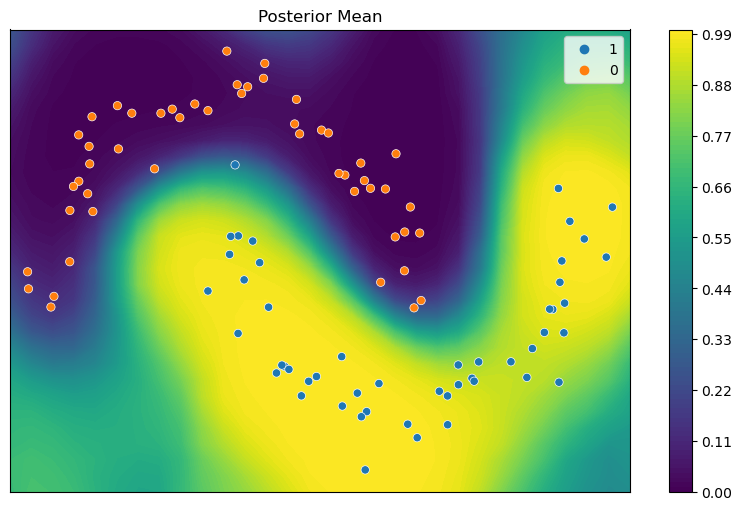

In [26]:
plot_pyro_predictions(posterior_samples=mcmc_samples, x=x, y=y) 

Plot the posterior predictive mean function over a finite grid of points, together with the training data. Comment on the results.

The classifier seems to be performing quite well, and is capable of determining the non-linear boundary which separates the two classes.
There is some chance that it would misclassify some of the at the "tip" of the two moons, but overall it works quite well, as it identifies the data shape.